In [1]:
# For extracting files from Amazon S3 Buckets
import boto3
from botocore import UNSIGNED
from botocore.client import Config

# For PySpark
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType

# For Delta Lake
from delta import *

# For VGG16 Model
from keras.applications.vgg16 import VGG16 
from keras.models import Model
from keras.applications.vgg16 import preprocess_input

# For PCA and Kmeans
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Working with images
from PIL import Image
import io
import base64
import numpy as np

In [2]:
# Connect to Amazon S3 Buckets
s3 = boto3.resource('s3', config=Config(signature_version=UNSIGNED))
bucket = s3.Bucket("airborne-obj-detection-challenge-training")
bucket_objects = bucket.objects.filter(Prefix="part1/Images/1497343b9d90411db5c305e785be9032")

/usr/local/lib/python3.6/dist-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [3]:
import os
import sys
os.environ["SPARK_HOME"] = "/opt/spark-3.0.1-bin-hadoop2.7"
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [4]:
# These 2 links include the jar files needed to interact with AWS S3
!wget https://repo1.maven.org/maven2/com/amazonaws/aws-java-sdk/1.7.4/aws-java-sdk-1.7.4.jar -P $SPARK_HOME/jars/
!wget https://repo1.maven.org/maven2/org/apache/hadoop/hadoop-aws/2.7.3/hadoop-aws-2.7.3.jar -P $SPARK_HOME/jars/

--2022-05-12 14:45:26--  https://repo1.maven.org/maven2/com/amazonaws/aws-java-sdk/1.7.4/aws-java-sdk-1.7.4.jar
Resolving repo1.maven.org (repo1.maven.org)... 151.101.148.209
Connecting to repo1.maven.org (repo1.maven.org)|151.101.148.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11948376 (11M) [application/java-archive]
Saving to: ‘/opt/spark-3.0.1-bin-hadoop2.7/jars/aws-java-sdk-1.7.4.jar’

aws-java-sdk-1.7.4. 100%[===================>]  11.39M  5.44MB/s    in 2.1s    

2022-05-12 14:45:29 (5.44 MB/s) - ‘/opt/spark-3.0.1-bin-hadoop2.7/jars/aws-java-sdk-1.7.4.jar’ saved [11948376/11948376]

--2022-05-12 14:45:29--  https://repo1.maven.org/maven2/org/apache/hadoop/hadoop-aws/2.7.3/hadoop-aws-2.7.3.jar
Resolving repo1.maven.org (repo1.maven.org)... 151.101.148.209
Connecting to repo1.maven.org (repo1.maven.org)|151.101.148.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 126287 (123K) [application/java-archive]
Saving to: ‘/op

In [5]:
spark = SparkSession.builder.appName("drones") \
    .config("spark.executor.memory", "15g") \
    .config("spark.driver.memory", "15g") \
    .config("spark.jars.packages", "io.delta:delta-core_2.12:0.7.0") \
    .config("spark.delta.logStore.class", "org.apache.spark.sql.delta.storage.S3SingleDriverLogStore") \
    .getOrCreate()

sc = spark.sparkContext
spark

In [6]:
# Connect to Amazon S3 Buckets
s3 = boto3.resource('s3', config=Config(signature_version=UNSIGNED))
bucket = s3.Bucket("airborne-obj-detection-challenge-training")
bucket_objects = bucket.objects.filter(Prefix="part1/Images/1497343b9d90411db5c305e785be9032")

In [7]:
# Store file paths and image content
img_path = []
img_content = []

schema = StructType([StructField("img_path", StringType()),
                    StructField("img_content", StringType())])

for obj in bucket_objects:
    img_path = []
    img_content = []
    if obj.key.endswith("171497343b9d90411db5c305e785be9032.png"):
        img_path.append(obj.key)
        temp_img = obj.get()['Body'].read()
        
        img = Image.open(io.BytesIO(temp_img))
        img1 = img.convert('RGB').resize((224,224))
        
        buffered = io.BytesIO()
        img1.save(buffered, format = "png")
        png_encoded = base64.b64encode(buffered.getvalue())
        
        img_content.append(str(png_encoded))
        
        img_path_rdd = sc.parallelize(img_path)
        img_content_rdd = sc.parallelize(img_content)
        zipped_rdd = img_path_rdd.zip(img_content_rdd).collect()

        df = spark.createDataFrame(zipped_rdd, schema)
        df.write.format("delta").mode("append").save("s3a://drones-project-test/sample-table5/")

In [8]:
# Read in delta table
df = spark.read.format("delta").load("s3a://drones-project-test/sample-table5/")
df.count()

20

In [9]:
df.show(40)

+--------------------+--------------------+
|            img_path|         img_content|
+--------------------+--------------------+
|part1/Images/1497...|b'iVBORw0KGgoAAAA...|
|part1/Images/1497...|b'iVBORw0KGgoAAAA...|
|part1/Images/1497...|b'iVBORw0KGgoAAAA...|
|part1/Images/1497...|b'iVBORw0KGgoAAAA...|
|part1/Images/1497...|b'iVBORw0KGgoAAAA...|
|part1/Images/1497...|b'iVBORw0KGgoAAAA...|
|part1/Images/1497...|b'iVBORw0KGgoAAAA...|
|part1/Images/1497...|b'iVBORw0KGgoAAAA...|
|part1/Images/1497...|b'iVBORw0KGgoAAAA...|
|part1/Images/1497...|b'iVBORw0KGgoAAAA...|
|part1/Images/1497...|b'iVBORw0KGgoAAAA...|
|part1/Images/1497...|b'iVBORw0KGgoAAAA...|
|part1/Images/1497...|b'iVBORw0KGgoAAAA...|
|part1/Images/1497...|b'iVBORw0KGgoAAAA...|
|part1/Images/1497...|b'iVBORw0KGgoAAAA...|
|part1/Images/1497...|b'iVBORw0KGgoAAAA...|
|part1/Images/1497...|b'iVBORw0KGgoAAAA...|
|part1/Images/1497...|b'iVBORw0KGgoAAAA...|
|part1/Images/1497...|b'iVBORw0KGgoAAAA...|
|part1/Images/1497...|b'iVBORw0K

In [10]:
df.explain(mode='cost')

== Optimized Logical Plan ==
Relation[img_path#8017,img_content#8018] parquet, Statistics(sizeInBytes=1109.3 KiB)

== Physical Plan ==
*(1) ColumnarToRow
+- FileScan parquet [img_path#8017,img_content#8018] Batched: true, DataFilters: [], Format: Parquet, Location: TahoeLogFileIndex[s3a://drones-project-test/sample-table5], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<img_path:string,img_content:string>




In [11]:
# keep only image content
images_df = df.rdd.map(lambda x: x["img_content"])
n_images = images_df.count()
content = images_df.take(n_images)

In [12]:
# Setup VGG16 Model
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

553467904/553467096 [==============================] - 30s 0us/step


In [13]:
data = {}

for i in range(n_images):
    png_decoded = base64.b64decode(content[i][1:])
    img = Image.open(io.BytesIO(png_decoded))
    img2 = np.array(img)
    reshaped_img = img2.reshape(1,224,224,3)
    imgx = preprocess_input(reshaped_img)
    features = model.predict(imgx, use_multiprocessing=True)
    data[i] = features

In [14]:
feat = np.array(list(data.values())).reshape(-1,4096)
pca = PCA(n_components = 20, random_state = 22)
pca.fit(feat)
x = pca.transform(feat)
print("Components before PCA:", feat.shape[1])
print("Components after PCA:", pca.n_components)

Components before PCA: 4096
Components after PCA: 20


In [15]:
kmeans = KMeans(n_clusters=4, random_state=22)
kmeans.fit(x)
kmeans.labels_

array([1, 1, 1, 2, 2, 2, 2, 0, 1, 0, 2, 2, 0, 2, 2, 3, 3, 3, 3, 3],
      dtype=int32)

Text(0, 0.5, 'Sum of squared distance')

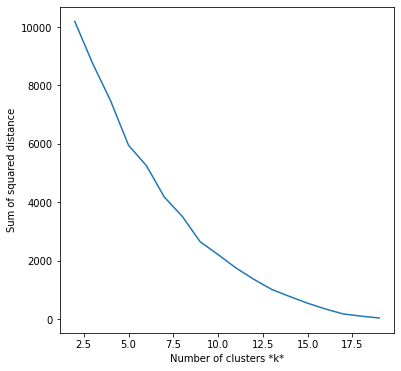

In [16]:
sse = []
list_k = list(range(2, 20))
for k in list_k:
    km = KMeans(n_clusters=k, random_state=22)
    km.fit(x)
    
    sse.append(km.inertia_)
# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse)
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')